In [1]:
using Pkg
Pkg.activate("../..")

  Activating project at `~/Documents/repos/nanoOpt.jl`


In [2]:
using Measures,LinearAlgebra,LazyGrids,LaTeXStrings,QuadGK,Plots; pyplot()

Plots.PyPlotBackend()

In [3]:
include("../../src/NanoOpt.jl")

getEfieldInside (generic function with 1 method)

In [4]:
kyi(β::Number,kᵢ::Number) = zsqrt(Complex(kᵢ^2 - β^2))

function funSolv(β::Number,k₀::Number,layer::layerstructure)
    d = layer.z[end]
    
    matStr = layer.mat
    intr12 = layerstructure([matStr[1],matStr[2]],[0.,],"up")
    intr23 = layerstructure([matStr[2],matStr[3]],[0.,],"up")
    
    ky2 = kyi(β,matStr[2].k(k₀))
    
    RT12 = rtcoeffs(intr12,k₀,[β,],"up")
    R12 = RT12.r.TM[1]

    RT23 = rtcoeffs(intr23,k₀,[β,],"up")
    R23 = RT23.r.TM[1]
    
    #kz1,kz2,kz3 = kyi(β,matStr[1].k(k₀)),kyi(β,matStr[2].k(k₀)),kyi(β,matStr[3].k(k₀))
    #ε1,ε2,ε3 = matStr[1].ε(k₀),matStr[2].ε(k₀),matStr[3].ε(k₀)
    #R12 = (ε2*kz1-ε1*kz2)/(ε2*kz1+ε1*kz2)
    #R23 = (ε3*kz2-ε2*kz3)/(ε3*kz2+ε2*kz3)
    
    
    1 + R12*R23*exp(2*im*ky2*d)
end

function DerfunSolv(β::Number,k₀::Number,layer::layerstructure)
    d = layer.z[end]
    
    matStr = layer.mat
    intr12 = layerstructure([matStr[1],matStr[2]],[0.,],"up")
    intr23 = layerstructure([matStr[2],matStr[3]],[0.,],"up")
    
    ky2 = kyi(β,matStr[2].k(k₀)); ky1 = kyi(β,matStr[1].k(k₀)); ky3 = kyi(β,matStr[3].k(k₀))
    ε1,ε2,ε3 = matStr[1].ε(k₀),matStr[2].ε(k₀),matStr[3].ε(k₀)
    
    RT12 = rtcoeffs(intr12,k₀,[β,],"up")
    R12 = RT12.r.TM[1]

    RT23 = rtcoeffs(intr23,k₀,[β,],"up")
    R23 = RT23.r.TM[1]
    
    dR12 = (2*β*k₀^2*ε1*ε2*(ε1 - ε2)) / (ky1*ky2*(ε2*ky1 + ε1*ky2)^2)
    dR23 = (2*β*k₀^2*ε2*ε3*(ε2 - ε3)) / (ky2*ky3*(ε3*ky2 + ε2*ky3)^2)
    
    (dR12*R23 + R12*dR23 - R12*R23*2*im*d*(β/ky2))*exp(2*im*ky2*d)*k₀
end

function NRSolver(βᵢ::Number,k₀::Number,layer::layerstructure,thr::Float64 = 1e-6)
    δ = 1e-6*(1+im)

    flag = true
    βₙ = 0 + im*0
    itr = 1
    
    while flag
        #βₙ = βᵢ + (funSolv(βᵢ,k₀,layer)/DerfunSolv(βᵢ,k₀,layer))
        βₙ = βᵢ - δ*funSolv(βᵢ,k₀,layer)/(funSolv(βᵢ+δ,k₀,layer)-funSolv(βᵢ,k₀,layer))
    
        #println("β = ",βₙ," thr = ",abs(βₙ - βᵢ))
    
        if abs(βₙ - βᵢ) ≤ thr || itr ≥ 300
            flag = false
        else
            βᵢ = βₙ
            itr += 1
        end
    end
    
    βₙ
end

function IsDifπ(βreal::Vector{Float64},βImag::Vector{Float64},k₀::Number,layer::layerstructure)
    flag = false
    βℜ,βℑ = ndgrid(βreal,βImag)

    βArr = βℜ+im*βℑ

    βAm = βArr[:]

    FM = reshape(angle.([funSolv(β,k₀,layer) for β in βAm]),(size(βArr)))

    difF = [abs(FM[1,1]-FM[1,2]), abs(FM[1,2]-FM[2,2]),abs(FM[2,2]-FM[2,1]),abs(FM[2,1]-FM[1,1])]

    arrπ = findall(difF .> π)


    if ~isempty(arrπ) 
        flag = length(arrπ) == 1 
    end

    flag
end

function getβc(βRec::Vector{Float64},βImc::Vector{Float64},N::Int64,k₀::Number,layer::layerstructure)
    βRRr = collect(LinRange(βRec[1],βRec[2],N))
    βRRi = collect(LinRange(βImc[1],βImc[2],N))

    βMMr,βMMi = ndgrid(βRRr,βRRi)
    βMM = βMMr + im*βMMi

    nx,ny = size(βMM)
    βc = 0+0*im
    flag = false
    for i in 1:nx-1
        for j in 1:ny-1

            βI= βMM[i:i+1,j:j+1]

            βreal = real(βI[:,1])
            βImag = imag(βI[1,:])

            flag = IsDifπ(βreal,βImag,k₀,layer)
            #println(flag)
            if flag
                βRc = sum(βreal)/2
                βIc = sum(βImag)/2

                βc = βRc+im*βIc
                #return βc
            end
        end
    end
    
    βc
end

function Λedge(θ::Number,ϕ::Number,λ₀::Number,n::Number)
    θᵣ = (θ*π)/180
    ϕᵣ = (ϕ*π)/180
    
    λ₀/(-sin(θᵣ)*sin(ϕᵣ)+sqrt((sin(θᵣ)^2)*(sin(ϕᵣ)^2)-sin(θ)^2+real(n)^2))
end

Λedge (generic function with 1 method)

In [5]:
mat1 = material((2.62)^2,1.0)
matSc = material(epstable("gold"),1.0)
#matSc = material(-13.02+im*1.033,1.0)
mat2 = material(1^2,1.0);

In [6]:
λ = 633
k₀ = 2π/λ
d = 2.;

In [7]:
layer = layerstructure([mat2,mat1,matSc],[0.0,d],"up");

In [8]:
layer.mat[3].ε(k₀)

-11.756181159254014 + 1.2330511027949578im

In [9]:
N = 200
ns = collect(LinRange(0.0103,0.011,N))
ins = collect(LinRange(4.e-5,6.1e-5,N));

In [10]:
nsM,insM = ndgrid(ns,ins)
nsA,insA = nsM[:],insM[:];

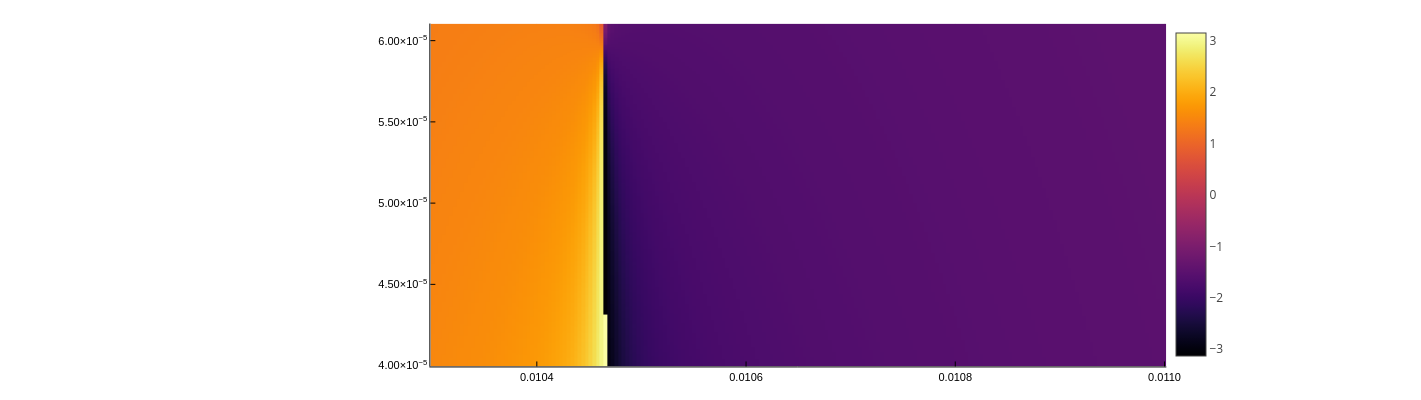

In [11]:
βT = (nsA+im*insA)

felA = [funSolv(β,k₀,layer) for β ∈ βT];

A = reshape(felA,size(nsM))

plotly()
heatmap(ns,ins,angle.(A)')

In [12]:
βRec = [ns[1], ns[end]]
βImc = [ins[1], ins[end]]

2-element Vector{Float64}:
 4.0e-5
 6.1e-5

In [13]:
βc = getβc(βRec,βImc,N,k₀,layer)

0.01046356783919598 + 5.9575376884422106e-5im

In [14]:
βS = NRSolver(βc,k₀,layer,1e-12)

0.010463809820075283 + 5.9561509375115934e-5im

In [15]:
funSolv(βS,k₀,layer)

3.2440716779547074e-13 - 4.623662563929543e-13im

In [16]:
nss = βS/k₀

1.0541773467255688 + 0.006000528965995491im

In [17]:
λspp = λ/real(nss)

600.468224787975

In [18]:
Λtl = λspp/2

300.2341123939875

In [19]:
Λedge(60,-3,λ,nss)

599.7214996927574

In [20]:
L = 1/(2k₀*imag(nss))

8394.683164441327

In [21]:
βRec = [0.00,0.03]
βImc = [0.0,6e-5]
N = 100

100

In [22]:
k0 = 2π/600

0.010471975511965976

In [23]:
λe = 350:10:800
k₀A = 2π ./ λe;

In [24]:
βtt = zeros(length(λe))*im

for i ∈ eachindex(k₀A)
    βc = getβc(βRec,βImc,N,k₀A[i],layer)
    βtt[i] = NRSolver(βc,k₀A[i],layer,1e-12)
end

In [25]:
plot(real(βtt),3e17k₀A,label=:none,xlabel="Re(β)")

In [26]:
plot(imag(βtt),3e17k₀A,label=:none,xlabel="Im(β)")

In [27]:
plot(λe,real(βtt./k₀A))

In [28]:
βtt

46-element Vector{ComplexF64}:
 0.018039104741950047 + 0.0020395118045117584im
  0.01755284539671244 + 0.0019592505069532546im
 0.017136035474154123 + 0.0018890983252878356im
 0.016733061622022333 + 0.0018139420568925979im
 0.016316512691329294 + 0.0017335013055612945im
  0.01591357906005072 + 0.0016681344617062747im
 0.015537457205149627 + 0.001621734075009904im
  0.01516846694744798 + 0.0015777542013528884im
 0.014817161108163002 + 0.0015468143336593875im
 0.014501600684612856 + 0.001545382708454615im
  0.01420150012905639 + 0.0015583264408363451im
 0.013894854276348872 + 0.0015705551581058487im
 0.013609578021416442 + 0.0015984876340088073im
                      ⋮
 0.023855883121539745 + 2.098023743169467e-6im
 0.023515088428169954 + 2.0584147353821603e-6im
 0.023183892320641886 + 2.021042524616179e-6im
 0.022865196162366035 - 2.5256738950710306e-6im
 0.022551965708656276 - 2.4916679348191954e-6im
 0.022247201215175035 - 2.4585730410878437e-6im
 0.021950563896419844 - 2.42613657858

In [29]:
 [NRSolver(βtt[i],k₀A[i],layer,1e-12) for i in 1:length(k₀A)]

46-element Vector{ComplexF64}:
 0.018039104741950023 + 0.0020395118045118013im
  0.01755284539671241 + 0.0019592505069532928im
   0.0171360354741541 + 0.0018890983252878514im
 0.016733061622022323 + 0.0018139420568926052im
  0.01631651269132929 + 0.0017335013055613017im
  0.01591357906005072 + 0.0016681344617062786im
 0.015537457205149622 + 0.0016217340750099092im
 0.015168466947447981 + 0.0015777542013528907im
 0.014817161108163002 + 0.001546814333659392im
 0.014501600684612856 + 0.0015453827084546195im
 0.014201500129056386 + 0.0015583264408363482im
 0.013894854276348867 + 0.0015705551581058521im
  0.01360957802141645 + 0.0015984876340087825im
                      ⋮
 0.023855883121939318 + 2.098023937759984e-6im
 0.023515088428301134 + 2.058414799339442e-6im
 0.023183892320643166 + 2.021042530530451e-6im
  0.02286519616234506 - 2.5256739044429555e-6im
 0.022551965708635078 - 2.491667934947426e-6im
 0.022247201215163204 - 2.4585730384979007e-6im
  0.02195056389641502 - 2.426136577063

In [30]:
 [funSolv(βtt[i],k₀A[i],layer) for i in 1:length(k₀A)]

46-element Vector{ComplexF64}:
  -5.551115123125783e-15 + 1.6181500583911657e-14im
  -7.771561172376096e-15 + 1.5237811012980274e-14im
  -7.771561172376096e-15 + 7.022160630754115e-15im
 -3.1086244689504383e-15 + 3.1086244689504383e-15im
 -1.3322676295501878e-15 + 2.9698465908722937e-15im
   2.220446049250313e-16 + 1.582067810090848e-15im
  -2.220446049250313e-15 + 2.3592239273284576e-15im
   5.551115123125783e-16 + 9.71445146547012e-16im
   2.220446049250313e-16 + 1.970645868709653e-15im
                     0.0 + 1.9984014443252818e-15im
 -1.5543122344752192e-15 + 1.3877787807814457e-15im
 -1.9984014443252818e-15 + 1.6930901125533637e-15im
   2.220446049250313e-15 - 1.0380585280245214e-14im
                         ⋮
   -0.014195640029271095 - 0.030241144527576987im
   -0.014562379481035226 - 0.03123651965517446im
   -0.014924380059535558 - 0.03221401012573012im
   -0.031205444382137015 + 0.0209874350368425im
    -0.03209014055729842 + 0.021620281711494927im
    -0.03297995438315193 